## Step 1: Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

## Step 2: Loading dataset

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
!unzip /content/gdrive/MyDrive/ASL\ Sign\ language.zip

Streaming output truncated to the last 5000 lines.
  inflating: Sign Language for Numbers/7/seven_549.jpg  
  inflating: Sign Language for Numbers/7/seven_55.jpg  
  inflating: Sign Language for Numbers/7/seven_550.jpg  
  inflating: Sign Language for Numbers/7/seven_551.jpg  
  inflating: Sign Language for Numbers/7/seven_552.jpg  
  inflating: Sign Language for Numbers/7/seven_553.jpg  
  inflating: Sign Language for Numbers/7/seven_554.jpg  
  inflating: Sign Language for Numbers/7/seven_555.jpg  
  inflating: Sign Language for Numbers/7/seven_556.jpg  
  inflating: Sign Language for Numbers/7/seven_557.jpg  
  inflating: Sign Language for Numbers/7/seven_558.jpg  
  inflating: Sign Language for Numbers/7/seven_559.jpg  
  inflating: Sign Language for Numbers/7/seven_56.jpg  
  inflating: Sign Language for Numbers/7/seven_560.jpg  
  inflating: Sign Language for Numbers/7/seven_561.jpg  
  inflating: Sign Language for Numbers/7/seven_562.jpg  
  inflating: Sign Language for Numbers/

### Transforming Dataset

In [3]:
data_dir = "/content/Sign Language for Numbers";

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(data_dir, transform = transform)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

#No j & z
print("Number of classes: ",len(dataset.classes))
print("Number of images: ",len(dataset.samples))

Number of classes:  11
Number of images:  16500


In [6]:
# Splitting dataset into train, validation and test

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
extra_size = len(dataset) - train_size - val_size - test_size
train_ds, val_ds, test_ds, extra_size = random_split(dataset, [train_size, val_size, test_size, extra_size])
len(train_ds), len(val_ds), len(test_ds)

(11550, 3300, 1650)

In [7]:
# from torchvision.models import resnet18, ResNet18_Weights

# model = resnet18()

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
from torch.autograd import Variable
from torch.nn.modules import loss
from torch.optim.adam import Adam

def train_model(lr, batch_size, optimizer, loss_function, num_epochs, train_dl, test_dl, val_dl):
#Model Training and saving best Model
  best_val_accuracy = 0.0
  epoch_val_accuracy = 0
  best_train_accuracy = 0.0
  epoch_train_accuracy = 0
  train_acc_list = []
  test_acc_list = []
  val_acc_list = []
  train_loss_list = []
  test_loss_list = []
  val_loss_list = []
  epo = []
  t1 = time.time()

  for epoch in range(num_epochs):
    # Train data set
    model.train()
    train_acc = 0.0
    train_loss = 0.0
    t2 = time.time()

    for i, (images, labels) in enumerate(train_dl):

        if(torch.cuda.is_available()):
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Train accuracy
        train_loss += loss.item()*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_acc += int(torch.sum(prediction==labels.data).item())

    train_acc = (train_acc / train_size)*100
    train_loss = train_loss / train_size

    # Test data set
    test_acc = 0.0
    test_loss = 0

    # Validation data set
    val_acc = 0.0
    val_loss = 0

    for i, (images, labels) in enumerate(val_dl):

        if(torch.cuda.is_available()):
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        val_loss += loss.item()*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        val_acc += int(torch.sum(prediction==labels.data))

    val_acc = (val_acc / val_size)*100
    val_loss = val_loss / val_size

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    val_loss_list.append(val_loss)
    epo.append(epoch+1)
    if (best_val_accuracy < round(val_acc, 3)) :
      best_val_accuracy = round(val_acc, 3)
      epoch_val_accuracy = epoch+1

    if (best_train_accuracy < round(train_acc, 3)) :
      best_train_accuracy = round(train_acc, 3)
      epoch_train_accuracy = epoch+1

    print('Epoch[{}]({:.0f} sec)  Train Loss: {:.4f}, Train Accuracy:  {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}\n'.format(epoch+1,time.time()-t2,train_loss,train_acc,test_loss,test_acc,val_loss,val_acc))
  
  print("######## Training Finished in {:.0f} seconds ###########".format(time.time()-t1))
  return train_acc_list, test_acc_list, val_acc_list, train_loss_list, test_loss_list, val_loss_list, epo, best_val_accuracy, epoch_val_accuracy, best_train_accuracy, epoch_train_accuracy

In [11]:
def place_graphs(lr, batch_size_arr, train_acc_arr, val_acc_arr, train_loss_arr, val_loss_arr, epo):
  plt.rcParams["figure.figsize"] = (20, 15)

  
  plt.subplot(2, 2, 1)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, train_acc_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs. No. of epochs with lr: '+ str(lr));
  plt.grid()
  # plt.show()

  # plt.rcParams["figure.figsize"] = (20, 5)
  # plt.subplot(3, 3, 2)
  # plt.xticks(epo)
  # for batch_size in batch_size_arr:
  #     plt.plot(epo, test_acc_arr[batch_size], label = "batch_size: " + str(batch_size))
  #     plt.legend(loc='best')
  # # plt.legend()
  # plt.xlabel('Epoch')
  # plt.ylabel('Accuracy')
  # plt.title('Test Accuracy vs. No. of epochs with lr: '+ str(lr));
  # plt.grid()
  # plt.show()

  plt.subplot(2, 2, 2)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, val_acc_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy vs. No. of epochs with lr: '+ str(lr));
  plt.grid()
  # plt.show()

  plt.subplot(2, 2, 3)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, train_loss_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Train Loss vs. No. of epochs with lr: '+ str(lr));
  plt.grid()
  # plt.show()

  plt.subplot(2, 2, 4)
  plt.xticks(epo)
  for batch_size in batch_size_arr:
      plt.plot(epo, val_loss_arr[batch_size], label = "batch_size: " + str(batch_size))
      plt.legend(loc='best')
  # plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Validation Loss vs. No. of epochs with lr: '+ str(lr));
  plt.grid()

  plt.show()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Lr: 0.01 batch size: 16
Epoch[1](40 sec)  Train Loss: 1.5917, Train Accuracy:  44.9177, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.8020, Val Accuracy: 76.0606

Epoch[2](31 sec)  Train Loss: 0.5210, Train Accuracy:  83.4632, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.3277, Val Accuracy: 86.1515

Epoch[3](32 sec)  Train Loss: 0.3157, Train Accuracy:  90.0087, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.2390, Val Accuracy: 89.3636

Epoch[4](31 sec)  Train Loss: 0.2332, Train Accuracy:  92.6840, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.0778, Val Accuracy: 93.2727

Epoch[5](31 sec)  Train Loss: 0.1789, Train Accuracy:  94.2165, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.3310, Val Accuracy: 93.1818

Epoch[6](32 sec)  Train Loss: 0.1490, Train Accuracy:  95.1342, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.5373, Val Accuracy: 94.6970

Epoch[7](31 sec)  Train Loss: 0.1384, Train Accuracy:  95.6017, Test Loss: 0.0000, Test Accura

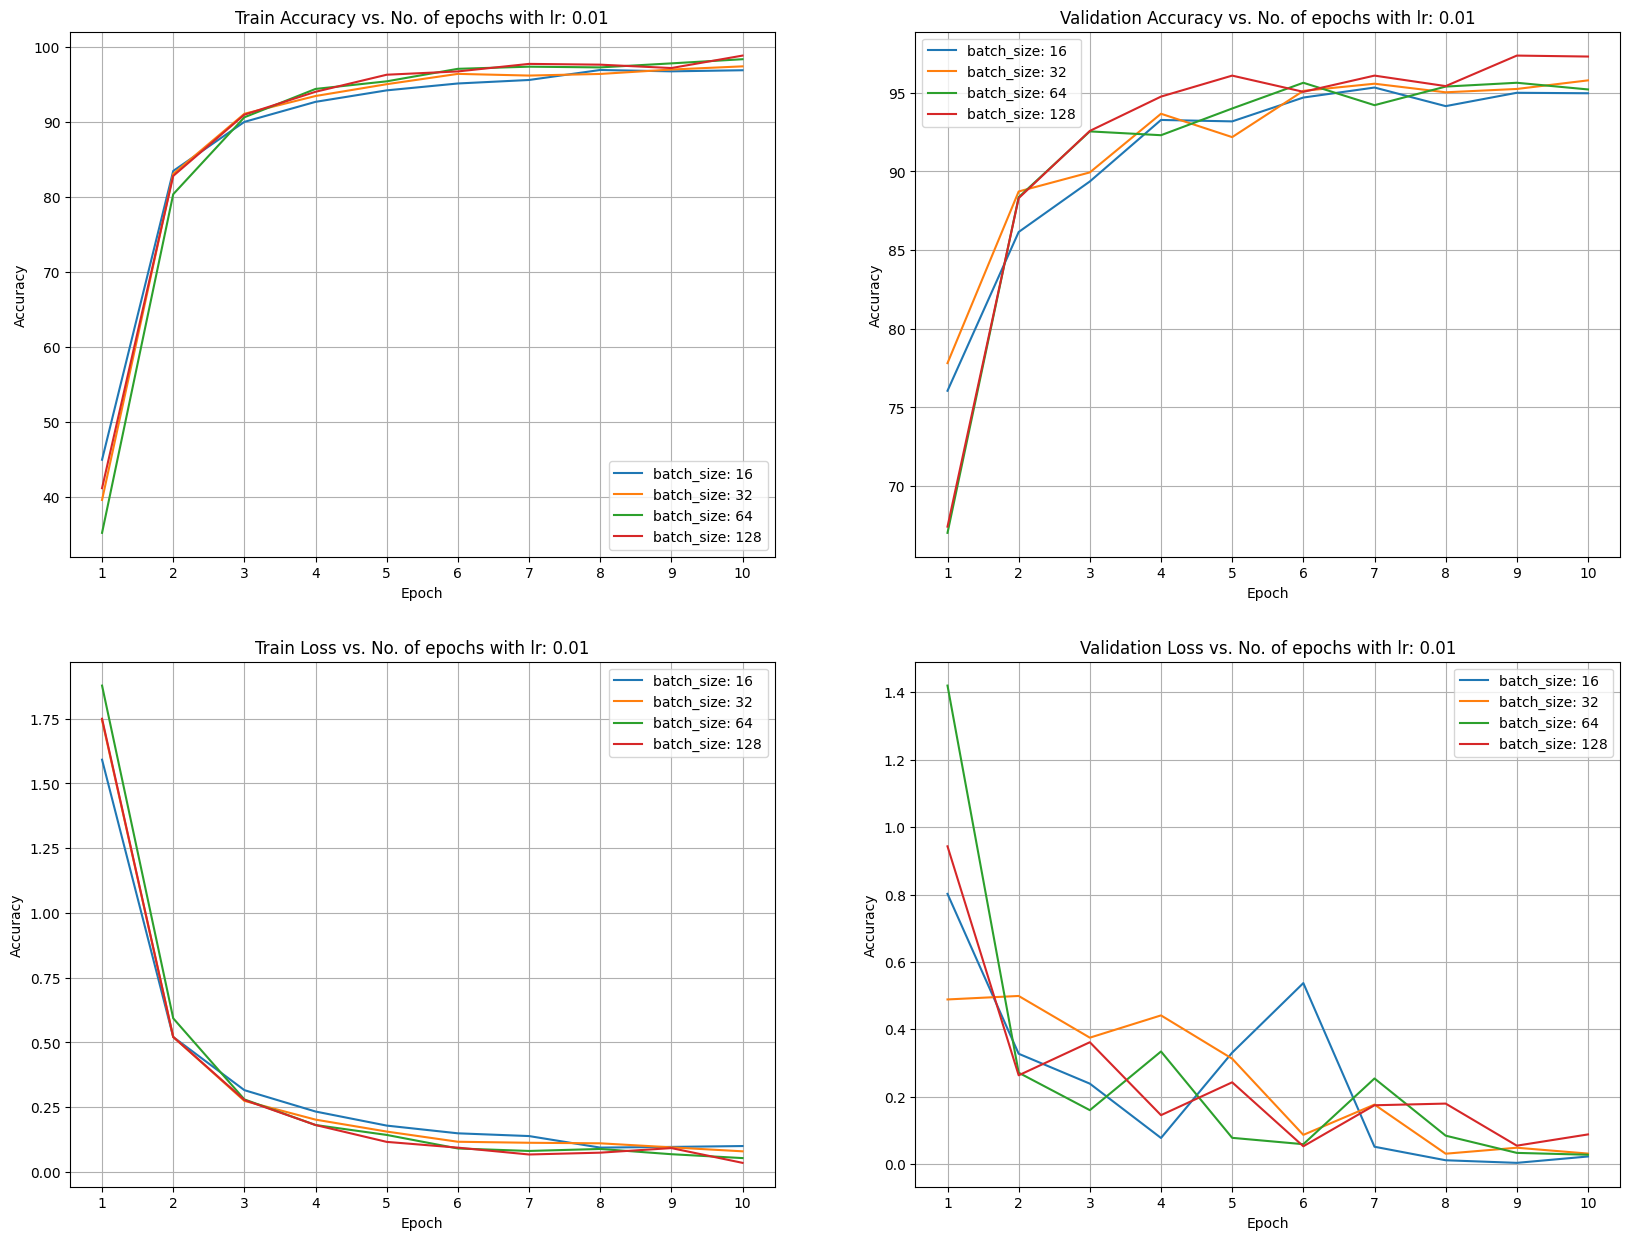

Lr: 0.001 batch size: 16
Epoch[1](32 sec)  Train Loss: 1.3467, Train Accuracy:  53.7922, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.8474, Val Accuracy: 81.8788

Epoch[2](31 sec)  Train Loss: 0.3676, Train Accuracy:  88.3377, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.1295, Val Accuracy: 89.7273

Epoch[3](32 sec)  Train Loss: 0.2009, Train Accuracy:  93.7662, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.1291, Val Accuracy: 90.3333

Epoch[4](31 sec)  Train Loss: 0.1468, Train Accuracy:  95.2814, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.1511, Val Accuracy: 94.1212

Epoch[5](31 sec)  Train Loss: 0.1219, Train Accuracy:  95.8788, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.0233, Val Accuracy: 95.5152

Epoch[6](31 sec)  Train Loss: 0.0948, Train Accuracy:  97.0563, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.0052, Val Accuracy: 95.0303

Epoch[7](31 sec)  Train Loss: 0.0860, Train Accuracy:  97.3333, Test Loss: 0.0000, Test Accur

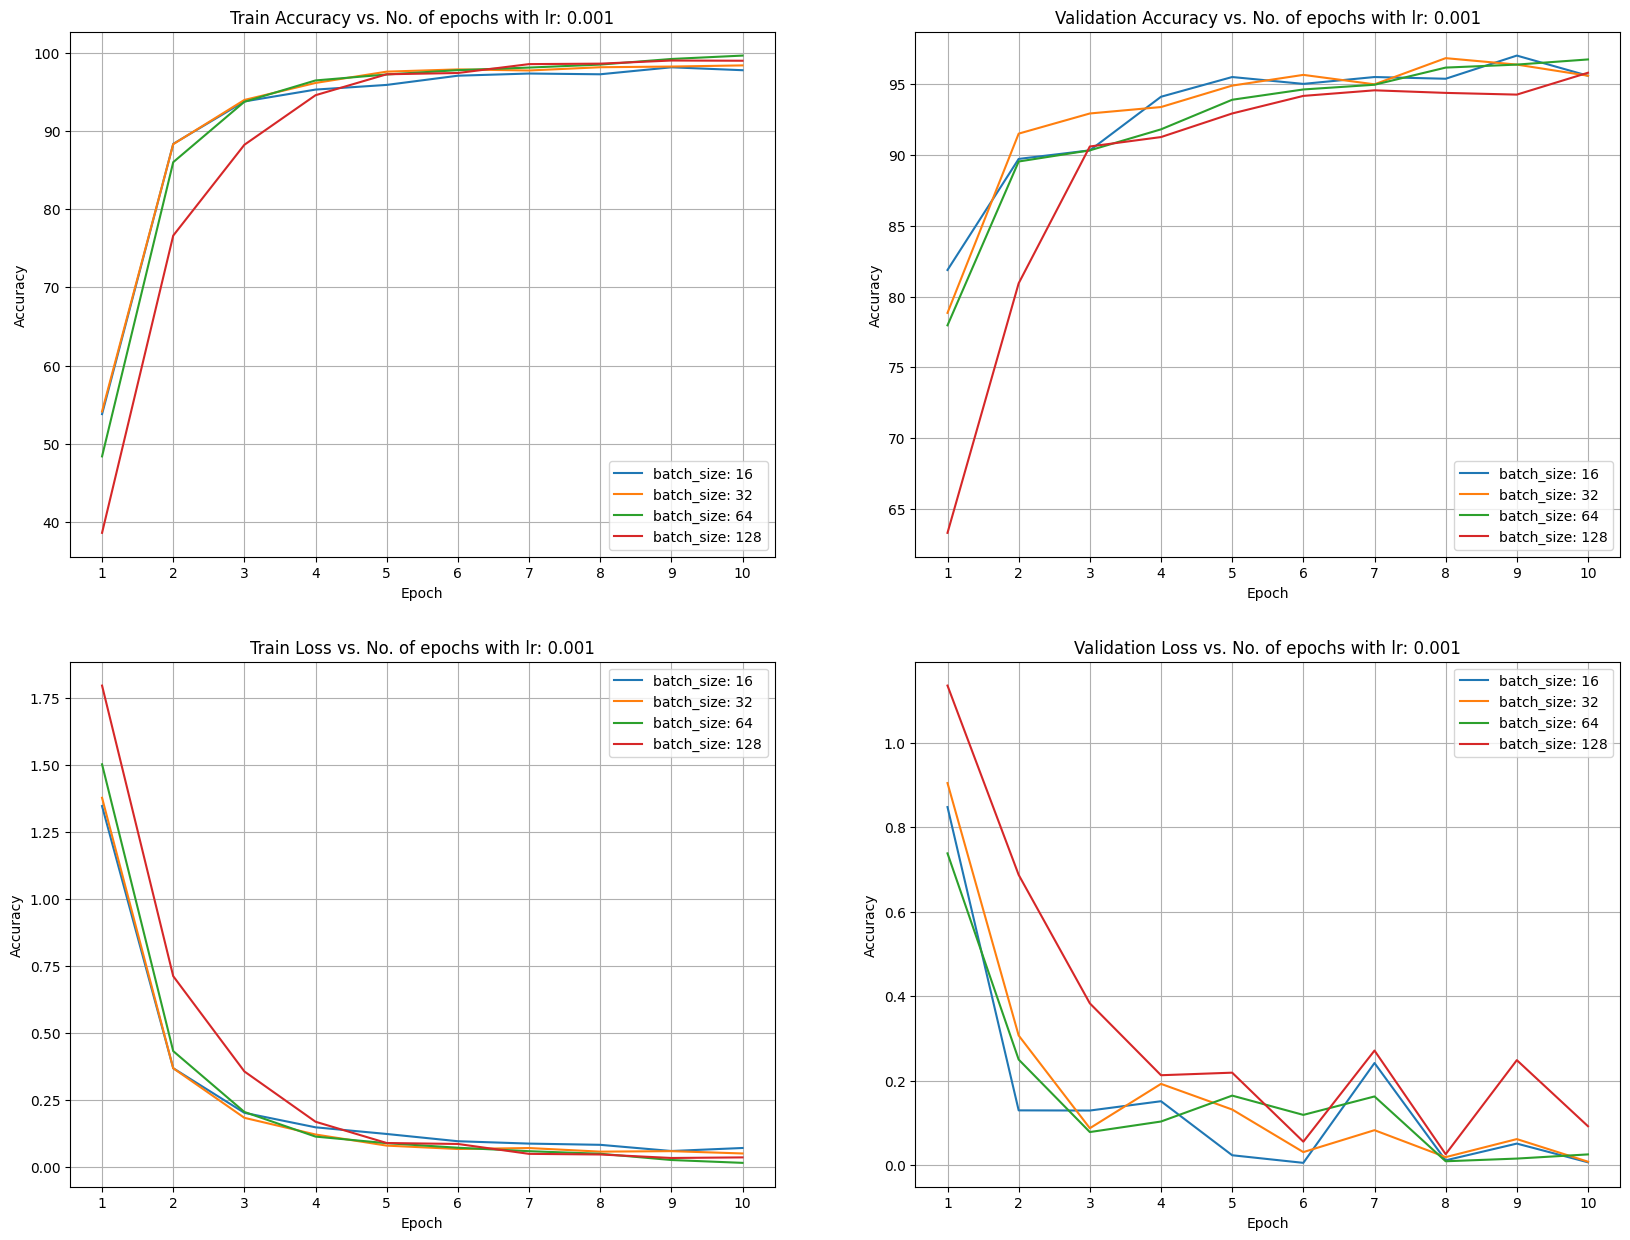

Lr: 0.0001 batch size: 16
Epoch[1](32 sec)  Train Loss: 2.1818, Train Accuracy:  24.9437, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 1.6954, Val Accuracy: 36.4848

Epoch[2](32 sec)  Train Loss: 1.4798, Train Accuracy:  50.8398, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 1.2274, Val Accuracy: 58.7273

Epoch[3](32 sec)  Train Loss: 0.9744, Train Accuracy:  67.9134, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.5197, Val Accuracy: 70.0909

Epoch[4](31 sec)  Train Loss: 0.7073, Train Accuracy:  76.9870, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 1.0317, Val Accuracy: 75.8485

Epoch[5](33 sec)  Train Loss: 0.5363, Train Accuracy:  82.4242, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.9346, Val Accuracy: 80.9091

Epoch[6](31 sec)  Train Loss: 0.4034, Train Accuracy:  87.1429, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 0.8746, Val Accuracy: 83.5455

Epoch[7](33 sec)  Train Loss: 0.3037, Train Accuracy:  90.1905, Test Loss: 0.0000, Test Accu

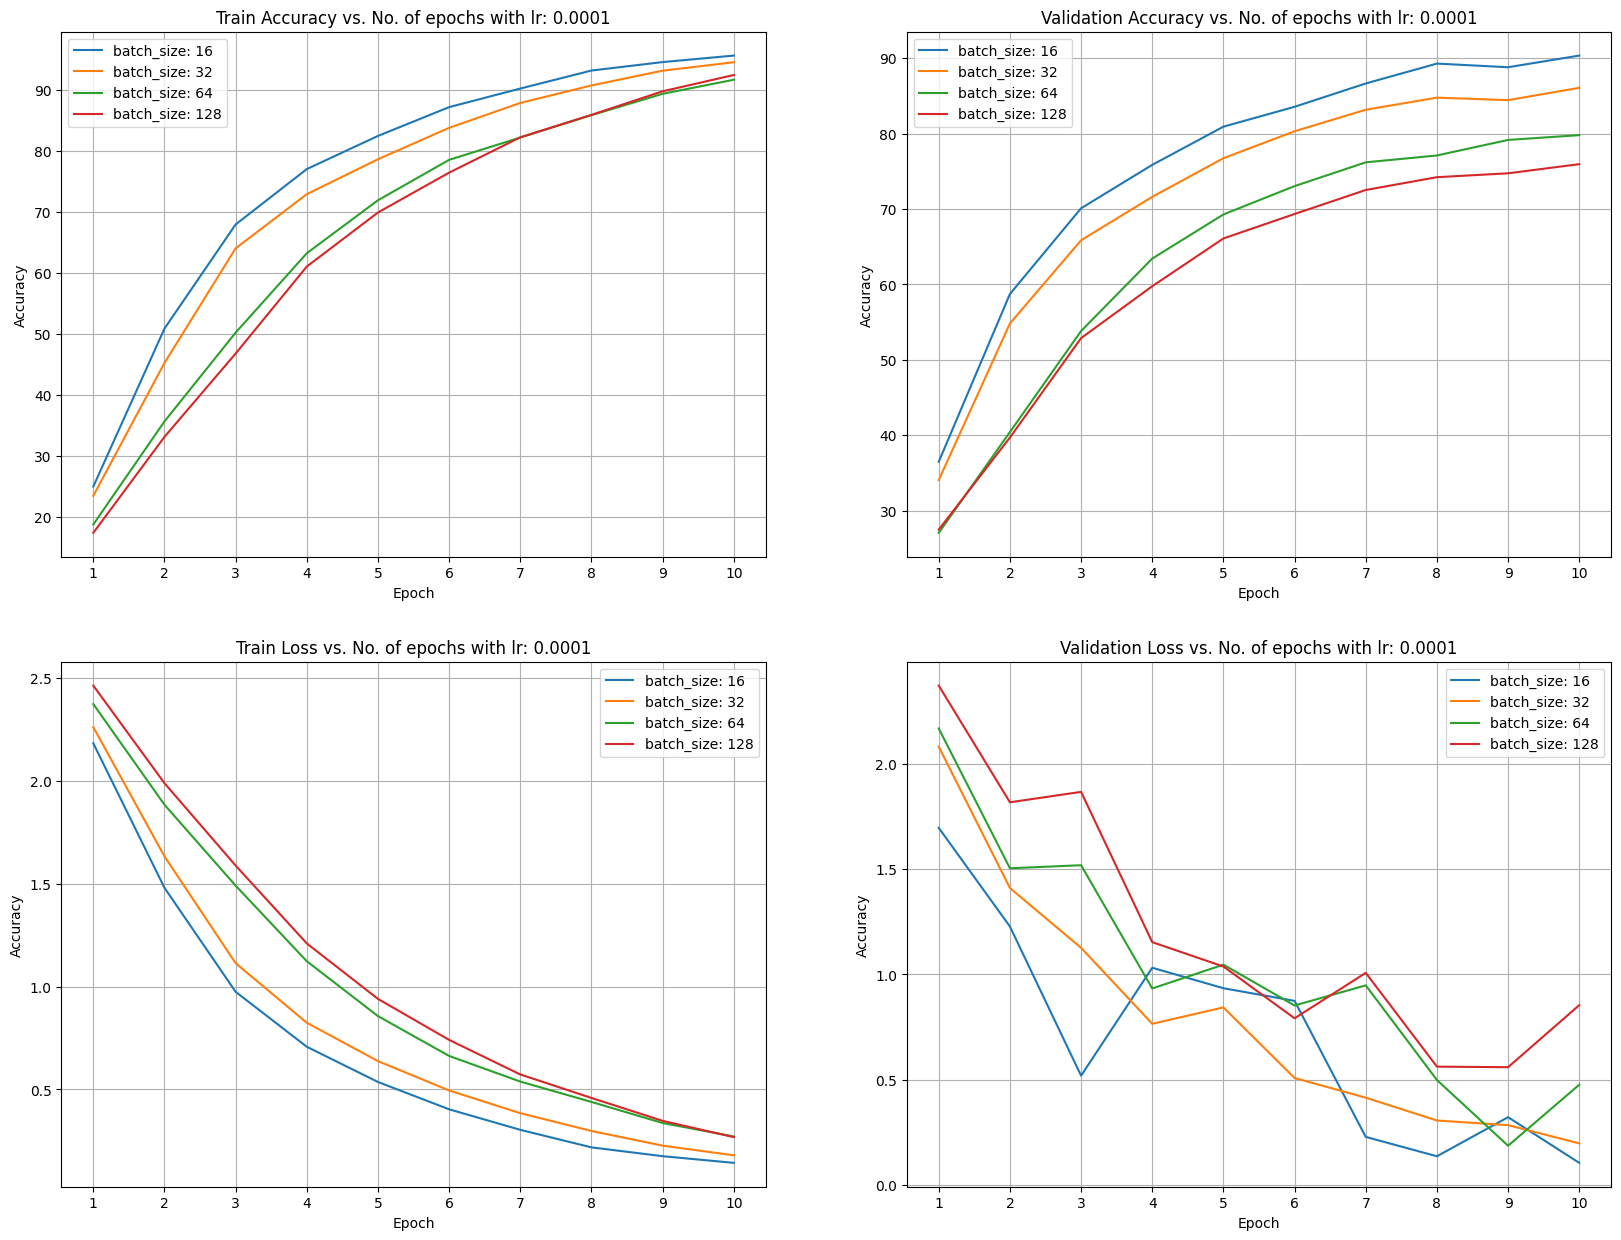

Lr: 1e-05 batch size: 16
Epoch[1](32 sec)  Train Loss: 2.6176, Train Accuracy:  13.1861, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 2.3152, Val Accuracy: 16.7273

Epoch[2](32 sec)  Train Loss: 2.3653, Train Accuracy:  17.4892, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 2.2887, Val Accuracy: 20.2121

Epoch[3](32 sec)  Train Loss: 2.2681, Train Accuracy:  21.9394, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 2.1296, Val Accuracy: 24.6970

Epoch[4](32 sec)  Train Loss: 2.1859, Train Accuracy:  25.3593, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 2.2167, Val Accuracy: 26.8788

Epoch[5](32 sec)  Train Loss: 2.0961, Train Accuracy:  28.2857, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 2.1940, Val Accuracy: 29.1515

Epoch[6](32 sec)  Train Loss: 2.0119, Train Accuracy:  31.7662, Test Loss: 0.0000, Test Accuracy: 0.0000, Val Loss: 1.9016, Val Accuracy: 31.4242

Epoch[7](32 sec)  Train Loss: 1.9237, Train Accuracy:  34.3636, Test Loss: 0.0000, Test Accur

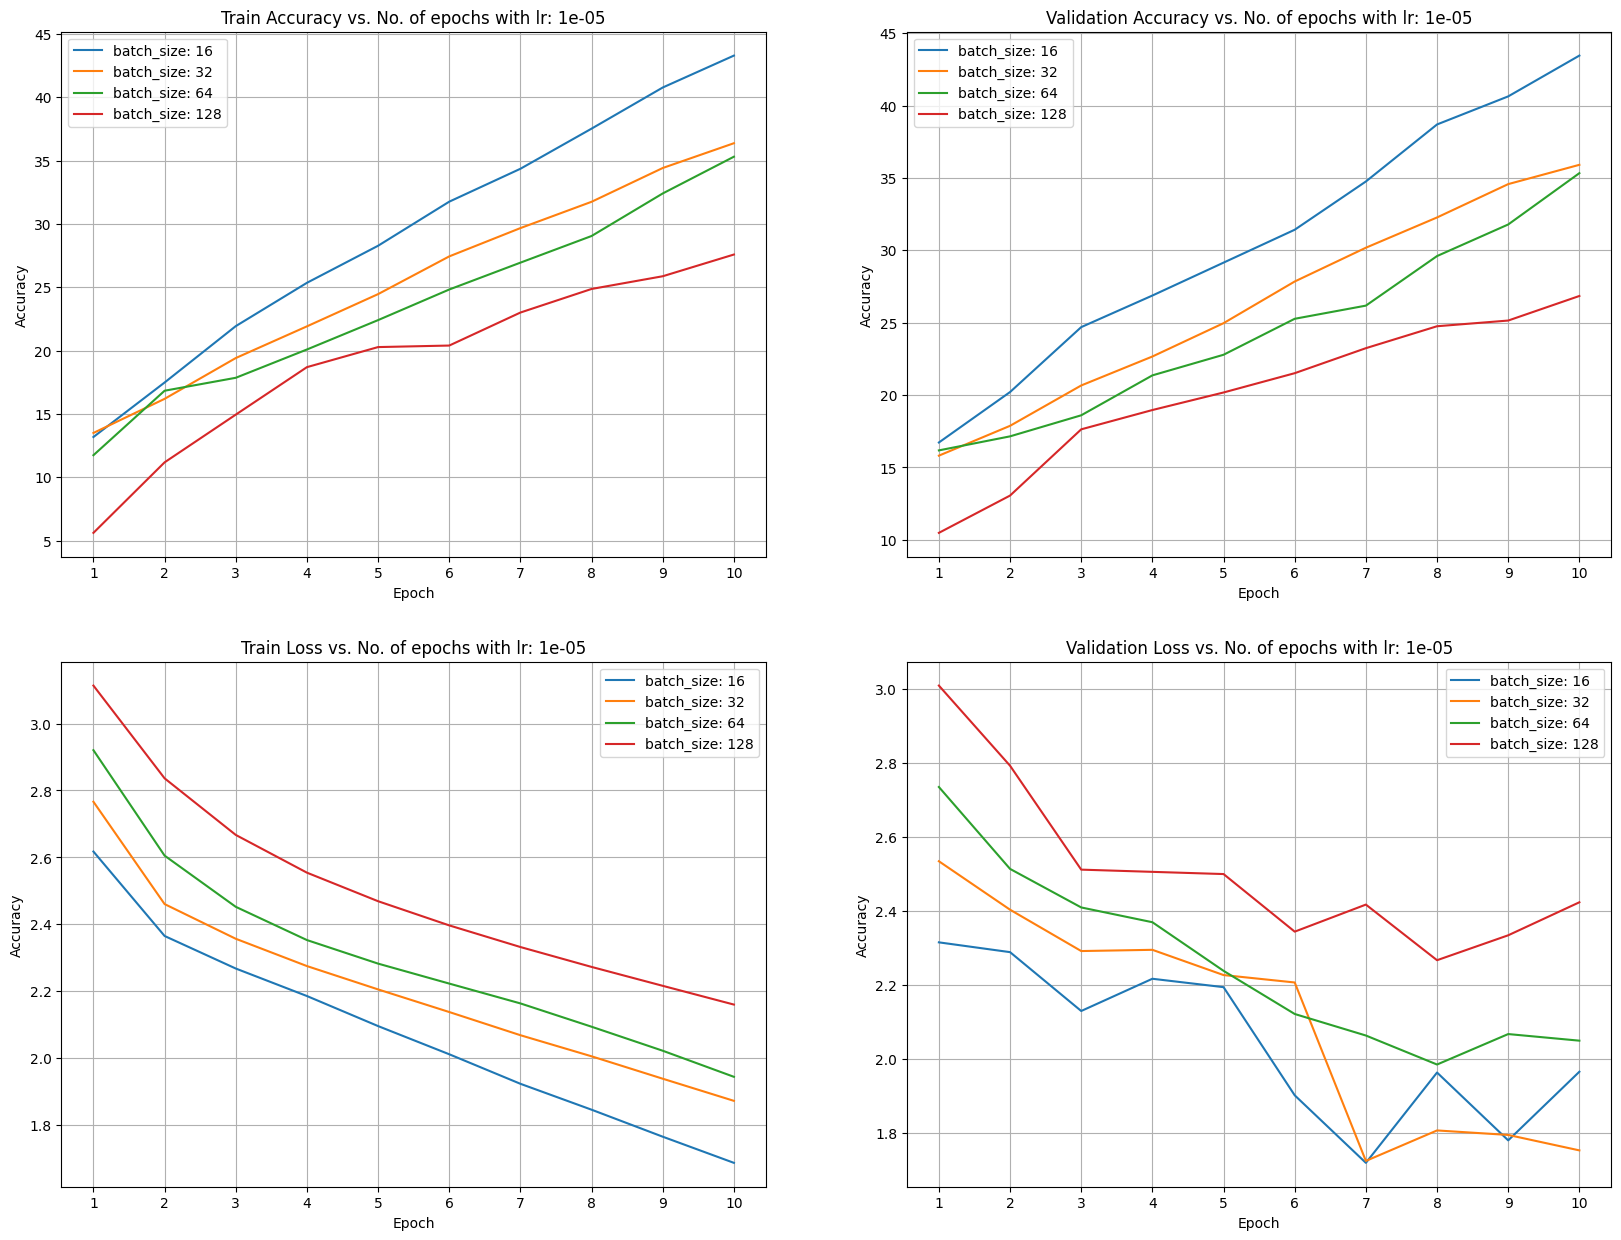


**********************************
BEST MODEL - lr = 1e-05 batch size = 128 val accuracy = 97.364 best_epoch_val_accuracy = 9


In [12]:
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet18, shufflenet_v2_x1_0

num_epochs = 10
lr_arr =  [0.01, 0.001, 0.0001, 0.00001]
batch_size_arr = [16, 32, 64, 128]
train_acc_arr = {}
test_acc_arr = {}
val_acc_arr = {}
train_loss_arr = {}
test_loss_arr = {}
val_loss_arr = {}
best_val_accuracy_main = 0.0
epoch_val_accuracy_main = 0
best_train_accuracy_main = 0.0
epoch_train_accuracy_main = 0
best_lr = 0
best_batch_size = 0

epo = []

for lr in lr_arr:

  for batch_size in batch_size_arr:

    model = shufflenet_v2_x1_0(pretrained=False, num_classes=24)
    # model.to(device)

    print('Lr: {} batch size: {}'.format(lr, batch_size))

    train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
    test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
    val_dl = DataLoader(val_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

    train_dl = DeviceDataLoader(train_dl, device)
    test_dl = DeviceDataLoader(test_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    to_device(model, device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss();

    train_acc_list, test_acc_list, val_acc_list, train_loss_list, test_loss_list, val_loss_list, epo, best_val_accuracy, epoch_val_accuracy, best_train_accuracy, epoch_train_accuracy = train_model(lr, batch_size, optimizer, loss_function, num_epochs, train_dl, test_dl, val_dl)

    train_acc_arr[batch_size] = train_acc_list
    test_acc_arr[batch_size] = test_acc_list
    val_acc_arr[batch_size] = val_acc_list
    train_loss_arr[batch_size] = train_loss_list
    test_loss_arr[batch_size] = test_loss_list
    val_loss_arr[batch_size] = val_loss_list

    if(best_val_accuracy_main < best_val_accuracy) :
      best_val_accuracy_main = best_val_accuracy
      best_epoch_val_accuracy = epoch_val_accuracy
      best_lr = lr
      best_batch_size = batch_size

    if(best_val_accuracy_main == best_val_accuracy) and (best_epoch_val_accuracy > epoch_val_accuracy) :
      best_val_accuracy_main = best_val_accuracy
      best_epoch_val_accuracy = epoch_val_accuracy
      best_lr = lr
      best_batch_size = batch_size

    torch.save(model.state_dict(), 'shuffle-net-numbers-batch_size'+str(batch_size)+ 'lr-' + str( lr)+'epochs-'+str(num_epochs)+'.pth')

  place_graphs(lr, batch_size_arr, train_acc_arr, val_acc_arr, train_loss_arr, val_loss_arr, epo)

print("\n**********************************")
print('BEST MODEL - lr = {} batch size = {} val accuracy = {} best_epoch_val_accuracy = {}'.format(lr, best_batch_size, best_val_accuracy_main, best_epoch_val_accuracy))
